<a href="https://colab.research.google.com/github/amyush/FrequencyDomain_Watermarking/blob/hideTheImage/watermarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting up the environment**

In [1]:
!git clone https://github.com/amyush/FrequencyDomain_Watermarking.git

Cloning into 'FrequencyDomain_Watermarking'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 33 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [2]:
import numpy as np
import cv2
import math
import pywt
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from PIL import Image as im
import math
from scipy.fftpack import dct
from scipy.fftpack import idct

# **Custom Functions**

In [10]:
def setParams():
    global sizeOrig 
    sizeOrig = 2048
    global sizeWatermark
    sizeWatermark = 128
    global alpha 
    alpha = 0.02
    global betaFactor
    betaFactor = 1
    global imgPath
    imgPath = "FrequencyDomain_Watermarking/"

def stringToBinary(a):
  l=[]
  res = ''.join(format(ord(i), '08b') for i in a)
  return res

def calculatePSNR(originalImage, encodedImage):
    originalImage = np.asarray(originalImage)
    encodedImage = np.asarray(encodedImage)
    error = np.sum((originalImage.astype('float') - encodedImage.astype('float')) ** 2)
    error /= float(originalImage.shape[0] * originalImage.shape[1]);
    if error == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(error))

def apply_dct(image_array):
    size = len(image_array[0])
    all_subdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct

    return all_subdct

def inverse_dct(all_subdct):
    size = len(all_subdct[0])
    all_subidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct

    return all_subidct

def process_coefficients(imArray, model, level):
    coeffs=pywt.wavedec2(data = imArray, wavelet = model, level = level)
    coeffs_H=list(coeffs) 
   
    return coeffs_H

# **Steganography**

## **Hiding the data**

In [7]:
def encodingImage(imageName, key, hiddenImageName):
    setParams();
    binKey = stringToBinary(key)
    lenBinKey = len(binKey)
    
    # Reading the cover image
    inputImage = Image.open(imgPath + imageName).convert('L')
    # Resizing the cover image so that it's dimension is compatible with the watermark image
    inputImage = inputImage.resize((sizeOrig,sizeOrig),Image.BILINEAR)
    # Converting the original image to array
    inputArray = np.array(inputImage.getdata(), dtype=np.float).reshape((sizeOrig,sizeOrig))

    # Reading the watermark image
    waterMarkImage = Image.open(imgPath + hiddenImageName).convert('L')
    # Resizing the logo image so that it's dimension is compatible with the cover image
    waterMarkImage = waterMarkImage.resize((sizeWatermark, sizeWatermark), Image.BILINEAR)
    waterMarkArray = np.array(waterMarkImage.getdata(), dtype=np.float).reshape((sizeWatermark,sizeWatermark))

    dctOrigArray = apply_dct(inputArray)
    dctWaterMarkArray = apply_dct(waterMarkArray)
    flatWaterMark = waterMarkArray.ravel()

    index = -1
    count = 0
    beta = betaFactor

    for x in range (0, dctOrigArray.shape[0], 16):
        for y in range (0, dctOrigArray.shape[1], 16):
            index = index + 1;
            if((int)(binKey[index%lenBinKey]) == 1):
                beta *= -1
            if count < flatWaterMark.size:
                subdct = dctOrigArray[x:x+16, y:y+16]
                subdct[12][12] = subdct[12][12] + alpha * beta * flatWaterMark[count]
                dctOrigArray[x:x+16, y:y+16] = subdct
                count += 1 
    
    idctArray = inverse_dct(dctOrigArray)
    resImage = cv2.imwrite('coverRes.png', idctArray)

## **Extracting the watermark image**

In [5]:
def extractImage(imageName, key, hiddenImageName):
    setParams();
    binKey = stringToBinary(key)
    lenBinKey = len(binKey)
    
    # Reading the cover image
    inputImage = Image.open(imgPath + imageName).convert('L')
    # Resizing the cover image so that it's dimension is compatible with the watermark image
    inputImage = inputImage.resize((sizeOrig,sizeOrig),Image.BILINEAR)
    # Converting the original image to array
    inputArray = np.array(inputImage.getdata(), dtype=np.float).reshape((sizeOrig,sizeOrig))

    # Reading the watermark image
    waterMarkImage = Image.open(imgPath + hiddenImageName).convert('L')
    # Resizing the logo image so that it's dimension is compatible with the cover image
    waterMarkImage = waterMarkImage.resize((sizeWatermark, sizeWatermark), Image.BILINEAR)
    waterMarkArray = np.array(waterMarkImage.getdata(), dtype=np.float).reshape((sizeWatermark,sizeWatermark))

    dctOrigArray = apply_dct(inputArray)
    dctWaterMarkArray = apply_dct(waterMarkArray)
    flatWaterMark = waterMarkArray.ravel()

    index = -1
    count = 0

    for x in range (0, dctOrigArray.shape[0], 16):
        for y in range (0, dctOrigArray.shape[1], 16):
            index = index + 1;
            if((int)(binKey[index%lenBinKey]) == 1):
                beta *= -1
            if count < flatWaterMark.size:
                subdct = dctOrigArray[x:x+16, y:y+16]
                subdct[12][12] = subdct[12][12] + alpha * beta * flatWaterMark[count]
                dctOrigArray[x:x+16, y:y+16] = subdct
                count += 1 
    
    idctArray = inverse_dct(dctOrigArray)
    resImage = cv2.imwrite('coverRes.png', idctArray)

# **Results**

In [8]:
# coverFileName = input("Enter the cover filename: (eg- cover.jpg or lena.png)")
# key = input("Enter the key:")
# waterMarkImageName = input("Enter the name of the image to be hidden: (eg- iitbbs_logo.jpeg or logo.png)")

coverFileName = 'cover.jpg'
key = 'Appa'
hiddenImageName = 'logo.png'

encodingImage(coverFileName, key, hiddenImageName)
 

57.15289875532164


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1dbd45a410>,
 Text(0.5, 1.0, 'Output Image'))

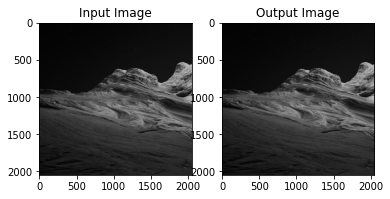

In [9]:
resImage = Image.open('coverRes.png')
inputImage = Image.open('FrequencyDomain_Watermarking/cover.jpg').convert('L')
inputImage = inputImage.resize((2048, 2048), Image.BILINEAR)
psnr = calculatePSNR(inputImage, resImage)
print(psnr)
plt.subplot(1,2,1),plt.imshow(inputImage.convert('RGB')), plt.title("Input Image")
plt.subplot(1,2,2),plt.imshow(resImage.convert('RGB')), plt.title("Output Image") 
